# 1. Import

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from mca import MCA
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import csv
import plotly.express as px

# 2. Load and parse the data

## Load the data

In [2]:
data = pd.read_csv('../data/FlightData.csv')
data

,from_airport_code,from_country,dest_airport_code,dest_country,aircraft_type,airline_number,airline_name,flight_number,departure_time,arrival_time,duration,stops,price,currency,co2_emissions,avg_co2_emission_for_this_route,co2_percentage,scan_date
0,ALG,Algeria,AEP,Argentina,Airbus A318|Canadair RJ 1000|Airbus A330|Airbu...,multi,[Air France| Iberia| LATAM],AF1491|AF1491|AF1491|AF1491,2022-04-30 14:30:00,2022-05-01 10:15:00,1425,3,1279.0,USD,1320000.0,1320000.0,0%,2022-04-29 17:52:59
1,ALG,Algeria,AEP,Argentina,Airbus A318|Canadair RJ 1000|Boeing 787|Airbus...,multi,[Air France| Iberia| LATAM],AF1491|AF1491|AF1491|AF1491,2022-04-30 14:30:00,2022-05-01 10:15:00,1425,3,1279.0,USD,1195000.0,1320000.0,-9%,2022-04-29 17:52:59
2,ALG,Algeria,AEP,Argentina,Airbus A320|Airbus A321|Boeing 787|Airbus A320,multi,[Air France| LATAM],AF1855|AF1855|AF1855|AF1855,2022-04-30 12:45:00,2022-05-01 10:15:00,1530,3,1284.0,USD,1248000.0,1320000.0,-5%,2022-04-29 17:52:59
3,ALG,Algeria,AEP,Argentina,Airbus A318|Airbus A320|Boeing 787|Airbus A320,multi,[Air France| LATAM],AF1491|AF1491|AF1491|AF1491,2022-04-30 14:30:00,2022-05-01 10:15:00,1425,3,1290.0,USD,1347000.0,1320000.0,2%,2022-04-29 17:52:59
4,ALG,Algeria,AEP,Argentina,Airbus A321neo|Boeing 777|Airbus A320,multi,[Lufthansa| LATAM],LH1317|LH1317|LH1317,2022-04-30 12:35:00,2022-05-01 10:15:00,1540,2,1347.0,USD,1381000.0,1320000.0,4%,2022-04-29 17:52:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998861,BOM,India,SYD,Australia,Boeing 777|Airbus A380,EK,[Emirates],EK503|EK503,2022-05-01 19:20:00,2022-05-02 22:05:00,1335,1,1317.0,USD,1567000.0,1133000.0,38%,2022-04-29 17:52:59
998862,BOM,India,SYD,Australia,Boeing 777|Airbus A380,EK,[Emirates],EK509|EK509,2022-05-01 22:20:00,2022-05-02 22:05:00,1155,1,1317.0,USD,1583000.0,1133000.0,39%,2022-04-29 17:52:59
998863,BOM,India,SYD,Australia,Airbus A350|Boeing 787|Boeing 737,multi,[Etihad| Virgin Australia],EY205|EY205|EY205,2022-05-01 04:35:00,2022-05-02 09:55:00,1490,2,1328.0,USD,1354000.0,1133000.0,19%,2022-04-29 17:52:59
998864,BOM,India,SYD,Australia,Airbus A321 (Sharklets)|Airbus A321|Airbus A330,multi,[Air India| SriLankan],AI603|AI603|AI603,2022-05-01 06:10:00,2022-05-02 14:55:00,1695,2,1368.0,USD,1099000.0,1133000.0,-2%,2022-04-29 17:52:59


## Remove the irrelevant columns
We will try to redict the price based on the all the other columns.

We will remove the following columns:
- departure_time, arrival_time: The type is datetime, and we don't handle datetime columns
- currency: The currency doesn't have any effect on the other columns
- from_country, dest_country: The country doesn't have any effect on the other columns, and we can find the country from the airport code
- flight_number: The flight number doesn't have any effect on the price
- scan_date: The scan date doesn't have any effect on the price
- co2_emissions: at first sight, co2 emissions don't seem to have an effect on price
- co2_percentage: at first sight, co2 percentage don't seem to have an effect on price

We will keep the following columns:
- from_airport_code and dest_airport_code
- aircraft_type
- airline_number, airline_name
- duration
- stops
- price
- avg_co2_emission_for_this_route

## Save the preprocessed data to a new file

In [3]:
data = data.drop(['departure_time', 'arrival_time', 'currency', 'from_country', 'dest_country', 'flight_number', 'scan_date', 'co2_emissions', 'co2_percentage'], axis=1)
data.to_csv('../data/PreprocessedFlightData.csv', index=False)

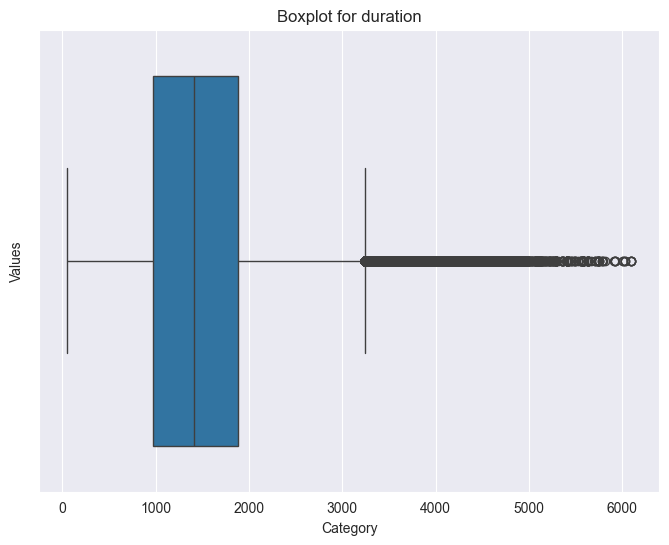

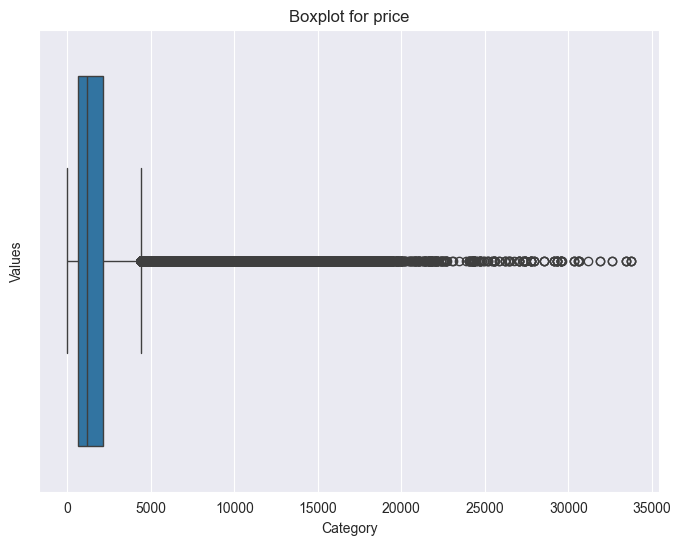

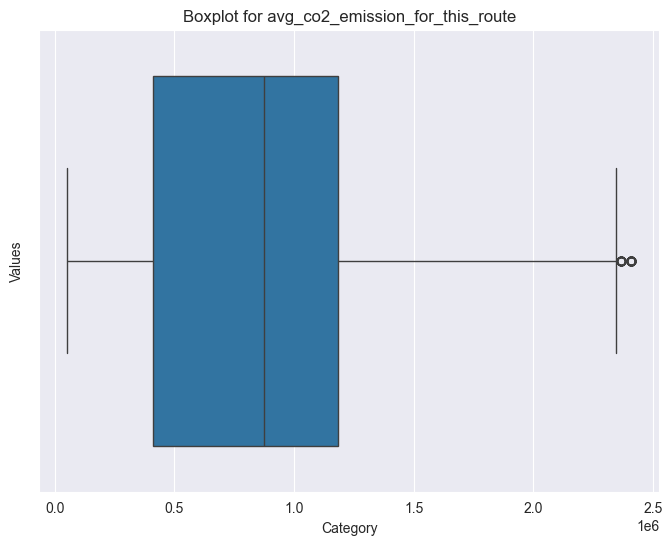

In [4]:
columns_to_plot = ['duration', 'price', 'avg_co2_emission_for_this_route']

for column in columns_to_plot:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=data[column])
    
    # Set labels and title
    plt.xlabel('Category')  # Replace with an appropriate label
    plt.ylabel('Values')    # Replace with an appropriate label
    plt.title(f'Boxplot for {column}')
    
    plt.show()

## Reduce the size of the dataset

the dataset has almost 1 million rows, this is too much for our computer to handle. We will reduce the size of the dataset to 10000 to make it easier to work with. we can always change the size of the dataset later if we need to.

In [5]:
# Take the large dataset and create a smaller subset of it.

input_file_path = '../data/PreprocessedFlightData.csv'
reduced_flight_data_path = '../data/ReducedFlightData.csv'

if os.path.exists(reduced_flight_data_path):
    os.remove(reduced_flight_data_path)

# choose how many rows to copy
rows_to_copy = 10000

# Method 1: using csv reader and writer

with open(input_file_path, 'r') as input_file, open(reduced_flight_data_path, 'w', newline='') as output_file:
    csv_reader = csv.reader(input_file)
    csv_writer = csv.writer(output_file)

    header = next(csv_reader)
    csv_writer.writerow(header)

    all_rows = list(csv_reader)

    rows_to_copy = min(rows_to_copy, len(all_rows))

    random_rows = random.sample(all_rows, rows_to_copy)
    for row in random_rows:
        csv_writer.writerow(row)

# Method 2: using pandas sample(VERY SLOW)
# pd.DataFrame.sample(
#     pd.read_csv(input_file_path),
#     n=6000,
#     random_state=42
# ).to_csv(reduced_flight_data_path, index=False)


print(f'Copied {rows_to_copy} random rows from {input_file_path} to {reduced_flight_data_path}')

Copied 10000 random rows from ../data/PreprocessedFlightData.csv to ../data/ReducedFlightData.csv


## Remove outliers
lets first create boxplots for the numerical columns to see if there are any outliers.

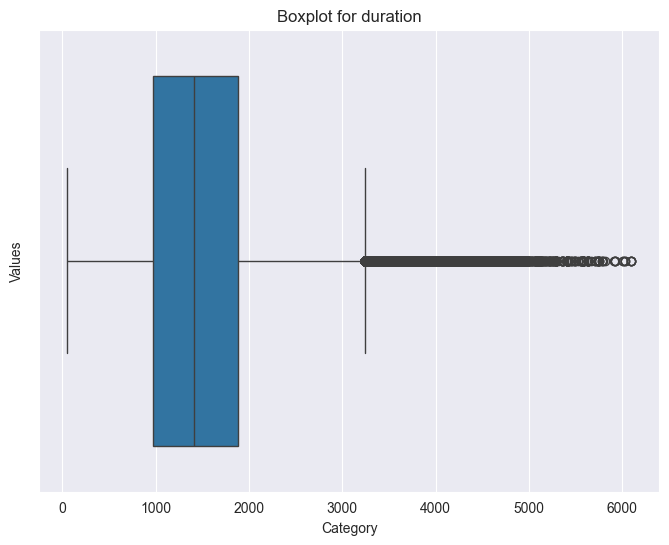

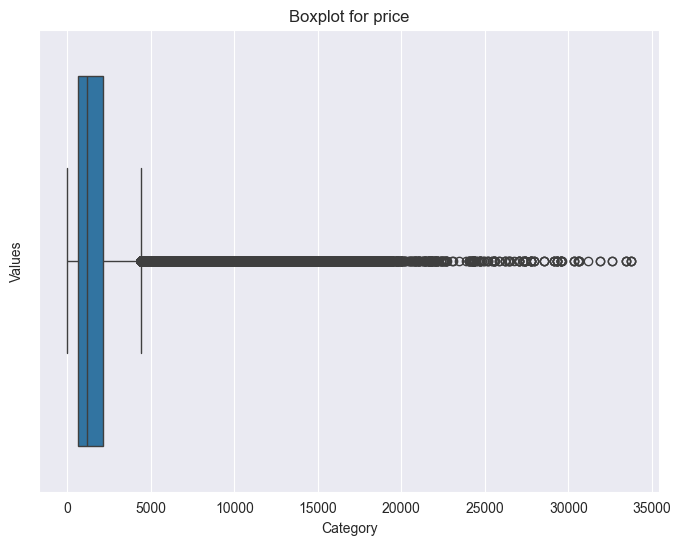

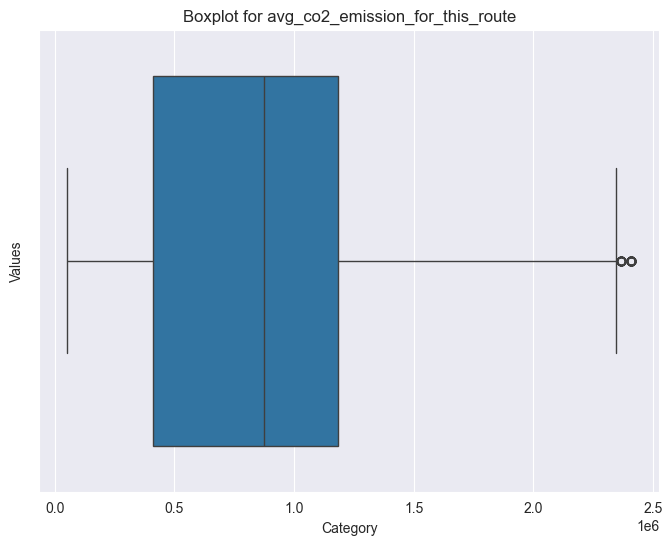

In [6]:
columns_to_plot = ['duration', 'price', 'avg_co2_emission_for_this_route']

for column in columns_to_plot:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=data[column])
    
    # Set labels and title
    plt.xlabel('Category')  # Replace with an appropriate label
    plt.ylabel('Values')    # Replace with an appropriate label
    plt.title(f'Boxplot for {column}')
    
    plt.show()

# 3. Split the data into train and test sets

In [7]:
data = pd.read_csv("../data/ReducedFlightData.csv")
full_data = pd.read_csv("../data/PreprocessedFlightData.csv")
train_size = round(data.shape[0] * 0.7)

train_data = data.iloc[:train_size].copy()
test_data = data.iloc[train_size:].copy()

# 4. Fill missing values

In [8]:
pd.DataFrame({
    'Na amount': data.isna().sum(),
    'Na percentage': data.isna().sum()/test_data.shape[0]
})

,Na amount,Na percentage
from_airport_code,0,0.000000
dest_airport_code,0,0.000000
aircraft_type,140,0.046667
airline_number,0,0.000000
airline_name,0,0.000000
duration,0,0.000000
stops,0,0.000000
price,21,0.007000
avg_co2_emission_for_this_route,904,0.301333


Here are all the columns with missing values and the way we will fill them:
- aircraft_type: we can fill the missing values with the most common aircraft type for the given route, airline and number of stops
- price: we can fill the missing values with the average price for the given route, airline and number of stops
- avg_co2_emission_for_this_route: we can fill the missing values with the average co2 emissions for the given route, airline and number of stops

In [9]:
for i, row in data[data['aircraft_type'].isnull()].iterrows():
    subset = full_data[(full_data['from_airport_code'] == row['from_airport_code']) & 
              (full_data['dest_airport_code'] == row['dest_airport_code']) & 
              (full_data['stops'] == row['stops']) &
              (full_data['airline_number'] == row['airline_number'])]

    if subset['aircraft_type'].isnull().sum() != subset.shape[0]:
        most_common_aircraft_type = subset['aircraft_type'].value_counts().idxmax()
        data.loc[i, 'aircraft_type'] = most_common_aircraft_type

In [10]:
for i, row in data[data['price'].isnull()].iterrows():
    subset = full_data[(full_data['from_airport_code'] == row['from_airport_code']) & 
              (full_data['dest_airport_code'] == row['dest_airport_code']) & 
              (full_data['stops'] == row['stops']) &
              (full_data['airline_number'] == row['airline_number'])]

    if subset['price'].isnull().sum() != subset.shape[0]:
        avg_price = subset['price'].mean()
        data.loc[i, 'price'] = avg_price

We can see that for some routes and number of stops, there are no values for the avg co2 emissions and the co2 percentage. We will fill these values with the average co2 emissions and co2 percentage for the given route and number of stops.

In [11]:
subset = full_data[(full_data['duration'] <= 3085+100) & 
          (full_data['duration'] >= 3085-100) & 
          (full_data['stops'] == 2) &
          (full_data['airline_number'] == 'multi') &
                   (full_data['aircraft_type'] == 'Boeing 777|Boeing 777|Airbus A330')]
subset

,from_airport_code,dest_airport_code,aircraft_type,airline_number,airline_name,duration,stops,price,avg_co2_emission_for_this_route
394,ALG,MEL,Boeing 777|Boeing 777|Airbus A330,multi,[Emirates| Qantas],3105,2,1688.0,NaN
395,ALG,MEL,Boeing 777|Boeing 777|Airbus A330,multi,[Emirates| Qantas],3105,2,1712.0,NaN
466,ALG,SYD,Boeing 777|Boeing 777|Airbus A330,multi,[Emirates| Qantas],3125,2,1551.0,NaN
469,ALG,SYD,Boeing 777|Boeing 777|Airbus A330,multi,[Emirates| Qantas],3145,2,1556.0,NaN
470,ALG,SYD,Boeing 777|Boeing 777|Airbus A330,multi,[Emirates| Qantas],3145,2,1564.0,NaN
479,ALG,SYD,Boeing 777|Boeing 777|Airbus A330,multi,[Emirates| Qantas],3100,2,3156.0,NaN
745,ALG,SYD,Boeing 777|Boeing 777|Airbus A330,multi,[Emirates| Qantas],3150,2,3179.0,NaN
261541,GRU,SGN,Boeing 777|Boeing 777|Airbus A330,multi,[Qatar Airways| Malaysia Airlines],3085,2,1343.0,2063000.0
261855,GRU,SGN,Boeing 777|Boeing 777|Airbus A330,multi,[Qatar Airways| Malaysia Airlines],3085,2,1186.0,2063000.0
564450,CPH,CNF,Boeing 777|Boeing 777|Airbus A330,multi,[Emirates| Tap Air Portugal],3170,2,1668.0,1240000.0


After doing some research, we found that trips with the same duration, number of stops, airline number and aircraft type have very different average co2 emissions. Earlier we saw that it could be a possibility to remove the avg co2 emissions and, so we will do that now.

In [12]:
data = data.drop(['avg_co2_emission_for_this_route'], axis=1)

In [13]:
pd.DataFrame({
    'Na amount': data.isna().sum(),
    'Na percentage': data.isna().sum() / test_data.shape[0]
})

,Na amount,Na percentage
from_airport_code,0,0.000000
dest_airport_code,0,0.000000
aircraft_type,49,0.016333
airline_number,0,0.000000
airline_name,0,0.000000
duration,0,0.000000
stops,0,0.000000
price,17,0.005667


For the remaining missing values, we will create one dataset where we deleted the missing values and one dataset where we filled the missing values with the average or max value for the given route and number of stops. We will then compare the two datasets and see which one is better.

### Method 1: Delete the avg co2 emissions and co2 percentage columns

In [26]:
data_deleted_na = data.dropna()

### Method 2: Fill the missing values with the average or max value for the given route and number of stops

In [15]:
for i, row in data[data['aircraft_type'].isnull()].iterrows():
    subset = full_data[(full_data['from_airport_code'] == row['from_airport_code']) &
                       (full_data['dest_airport_code'] == row['dest_airport_code']) &
                       (full_data['stops'] == row['stops'])]

    if subset['aircraft_type'].isnull().sum() != subset.shape[0]:
        most_common_aircraft_type = subset['aircraft_type'].value_counts().idxmax()
        data.loc[i, 'aircraft_type'] = most_common_aircraft_type

    most_common_aircraft_type = full_data['aircraft_type'].value_counts().idxmax()
    data.loc[i, 'aircraft_type'] = most_common_aircraft_type

In [16]:
for i, row in data[data['price'].isnull()].iterrows():
    subset = full_data[(full_data['from_airport_code'] == row['from_airport_code']) &
                       (full_data['dest_airport_code'] == row['dest_airport_code']) &
                       (full_data['stops'] == row['stops'])]

    if subset['price'].isnull().sum() != subset.shape[0]:
        avg_price = subset['price'].mean()
        data.loc[i, 'price'] = avg_price
        
    avg_price = full_data['price'].mean()
    data.loc[i, 'price'] = avg_price

## We will first start with the deleted_na dataset

## Fix the data types of the columns

In [28]:
data_deleted_na[['from_airport_code', 'dest_airport_code','aircraft_type','airline_number', 'stops', 'airline_name']] = data_deleted_na[['from_airport_code', 'dest_airport_code','aircraft_type','airline_number', 'stops', 'airline_name']].astype('category')
data_deleted_na.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   from_airport_code  10000 non-null  category
 1   dest_airport_code  10000 non-null  category
 2   aircraft_type      10000 non-null  category
 3   airline_number     10000 non-null  category
 4   airline_name       10000 non-null  category
 5   duration           10000 non-null  int64   
 6   stops              10000 non-null  category
 7   price              10000 non-null  float64 
dtypes: category(6), float64(1), int64(1)
memory usage: 478.1 KB


## Label encode the categorical columns

In [29]:
label_encoder = LabelEncoder()

data_deleted_na['from_airport_code'] = label_encoder.fit_transform(data_deleted_na['from_airport_code'])
data_deleted_na['dest_airport_code'] = label_encoder.fit_transform(data_deleted_na['dest_airport_code'])
data_deleted_na['aircraft_type'] = label_encoder.fit_transform(data_deleted_na['aircraft_type'])
data_deleted_na['airline_number'] = label_encoder.fit_transform(data_deleted_na['airline_number'])
data_deleted_na['stops'] = label_encoder.fit_transform(data_deleted_na['stops'])
data_deleted_na['airline_name'] = label_encoder.fit_transform(data_deleted_na['airline_name'])

data_deleted_na.head()

,from_airport_code,dest_airport_code,aircraft_type,airline_number,airline_name,duration,stops,price
0,23,36,2334,109,1771,2100,2,2247.0
1,15,76,1106,109,69,865,1,970.0
2,27,47,1381,109,476,2221,2,3123.0
3,9,30,192,57,1254,275,1,341.0
4,8,46,1080,109,750,2710,4,1754.0


In [30]:
data_deleted_na.to_csv('../data/processedData/deleted_na.csv', index=False)
data.to_csv('../data/processedData/filled_na.csv', index=False)

## Normalizing the data 

The different columns have very different ranges, so we will normalize the data to make it easier to work with.

We will normalize the data by subtracting the mean and dividing by the standard deviation.

In [20]:
mean_values = train_data_deleted_na[['duration', 'price']].mean()
std_values = train_data_deleted_na[['duration', 'price']].std()

train_data_deleted_na[['duration', 'price']] = (train_data_deleted_na[['duration', 'price']] - mean_values) / std_values
validation_data_deleted_na[['duration', 'price']] = (validation_data_deleted_na[['duration', 'price']] - mean_values) / std_values

train_data_deleted_na.head(), validation_data_deleted_na.head()

(   from_airport_code  dest_airport_code  aircraft_type  airline_number  \
 0                 23                 36           2334              98   
 1                 15                 76           1106              98   
 2                 27                 47           1381              98   
 3                  9                 30            192              50   
 4                  8                 46           1080              98   
 
    airline_name  duration  stops     price  
 0          1753  0.858468      2  0.213684  
 1            69 -0.844700      1 -0.409724  
 2           470  1.025337      2  0.641331  
 3          1241 -1.658359      1 -0.716790  
 4           742  1.699709      4 -0.026990  ,
       from_airport_code  dest_airport_code  aircraft_type  airline_number  \
 6999                 25                  4           1855              98   
 7000                  4                 12           2751              98   
 7001                  3             

In [21]:
data_deleted_na[['from_airport_code', 'dest_airport_code','aircraft_type','airline_number', 'stops', 'airline_name']].head()

,from_airport_code,dest_airport_code,aircraft_type,airline_number,stops,airline_name
0,23,36,2334,98,2,1753
1,15,76,1106,98,1,69
2,27,47,1381,98,2,470
3,9,30,192,50,1,1241
4,8,46,1080,98,4,742


## Principal component analysis (PCA)

array([ 71.32803364, 100.        ])

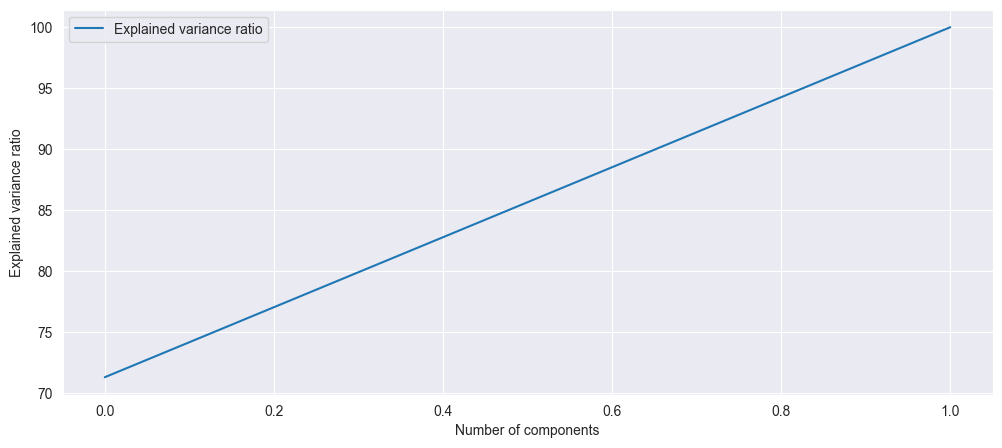

In [24]:
pca = PCA()
pca.fit(train_data_deleted_na[['duration', 'price']])

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(pca.explained_variance_ratio_.cumsum()*100,
        label="Explained variance ratio")
ax.set_xlabel("Number of components")
ax.set_ylabel("Explained variance ratio")
ax.legend()
pca.explained_variance_ratio_.cumsum()*100

We can see that the first 2 components explain 90% of the variance, so we will use 2 components.

In [25]:
pca = PCA(n_components=2)
pca.fit(train_data_deleted_na[['duration', 'price', 'co2_emissions']])

KeyError: "['co2_emissions'] not in index"

In [ ]:
train_data_deleted_pca = pd.DataFrame(pca.transform(train_data_deleted_na[['duration', 'price', 'co2_emissions']]), index=train_data_deleted_na.index, columns=['PC1', 'PC2'])
validation_data_deleted_pca = pd.DataFrame(pca.transform(validation_data_deleted_na[['duration', 'price', 'co2_emissions']]), index=validation_data_deleted_na.index, columns=['PC1', 'PC2'])

train_data_deleted_pca.head(), validation_data_deleted_pca.head()

In [ ]:
train_data_deleted_na.info()